# Introduction

## Import libraries

In [1]:
%matplotlib inline

import pandas as pd
import datetime 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import glob
import os
import sys
import itertools

import peakutils

import statsmodels.api as sm
from scipy.fftpack import fft

from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm


from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)


pd.plotting.register_matplotlib_converters()

import pickle
#https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict

import io
import requests

import platform
from matplotlib import rcParams

rcParams['figure.figsize'] = 15, 10
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:44: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.


In [2]:
waipypath = "G:/My Drive/Python/Pycharm/waipy/"
sys.path.append(waipypath)
import waipy

In [3]:
#llpath = "E:/My Drive/Python/Pycharm/loggerloader/"
llpath = "G:/My Drive/Python/Pycharm/loggerloader/"
sys.path.append(llpath)
import loggerloader as ll

## Database Connections

In [4]:
import importlib.util
spec = importlib.util.spec_from_file_location("dbconnect", "G:/My Drive/Python/dbconnect.py")
dbconnect = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dbconnect)

engine = dbconnect.postconn_leland(port=5433)
engine2 = dbconnect.postconn(port=5433)

## File Locations

In [5]:
file_place = "G:/My Drive/WORK/Leland_Harris/intermediate_data/"


## Links to Relevant Repos

https://github.com/pckujawa/harmonic_analysis_of_time_series<br>
https://github.com/gespinoza/hants<br>
http://nicolasfauchereau.github.io/climatecode/posts/wavelet-analysis-in-python/<br>

https://www.kaggle.com/asauve/a-gentle-introduction-to-wavelet-for-data-analysis


## Define Custom Functions

In [6]:
def scatterColor(x0,y,w):
    """Creates scatter plot with points colored by variable.
    All input arrays must have matching lengths

    Arg:
        x0 (array): 
            array of x values
        y (array): 
            array of y values
        w (array): 
            array of scalar values

    Returns:
        slope and intercept of best fit line
    
    """
    import matplotlib as mpl
    import matplotlib.cm as cm
    cmap = plt.cm.get_cmap('RdYlBu')
    norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array(w)
    sc = plt.scatter(x0, y, label='', color = m.to_rgba(w))

    xa = sm.add_constant(x0)

    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]

    x_prime = np.linspace(np.min(x0),np.max(x0),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    const = est.params[0]
    y2 = [i*slope + const for i in x0]

    plt.xlabel('Barometric Pressure (ft water)')
    plt.ylabel('Transducer Pressure (ft water)')
    lin = linregress(x0,y)
    x1 = np.arange(np.min(x0), np.max(x0),0.1)
    y1 = [i*lin[0]+lin[1] for i in x1]
    y2 = [i*slope+const for i in x1]
    plt.plot(x1,y1,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin[0],lin[1],lin[2]**2))
    plt.plot(x1,y2,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope,const,r2))
    plt.legend()
    cbar = plt.colorbar(m)

    cbar.set_label('Julian Date')

    return slope,const

def crosscorr(datax, datay, lag=0):
    ''' 
    http://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    '''
    return datax.corr(datay.shift(lag))

def plotlystuff(datasets, colnames, chrttypes=None, datatitles=None, chrttitle = 'well', colors=None,
                two_yaxes = False, axisdesig= None, axislabels=['Levels','Barometric Pressure']):
    """
    datasets = list of dataframes to plot
    colnames = list of column names for each df in datasets
    chrttypes = list of types of chart to plot for each dataset; options are markers, lines+markers, lines
    datatitles = labels to use for legend
    chrttitle = title for chart; default is well
    colors = list of colors to use for each dataset
    two_yaxes = turn on second y axis to show datasets at different scale (bool); defaults to False
    axisdesig = list of designations for each axis; y1 is left axist and y2 is right axis
    axislabels = labels to use for each y axis
    """
    if chrttypes is None:
        chrttypes = ['lines']*len(datasets)
    
    if datatitles is None:
        datatitles = colnames
    
    if axisdesig is None:
        axisdesig = ['y1']*len(datasets)
        
    if colors is None:
        if len(datasets) <= 5: 
            colors = ['#228B22','#F7DC6F','#FF1493','#663399','#FF0000']
        else:
            colors = []
            for i in range(len(datasets)):
                colors[i] = '#{:02x}{:02x}{:02x}'.format(r(), r(), r())
        
    r = lambda: random.randint(0,255)
    
    modetypes = ['markers','lines+markers','lines']
    datum = {}
    
    for i in range(len(datasets)):
        datum['d' + str(i)] = go.Scatter(
            x=datasets[i].index,
            y=datasets[i][colnames[i]],
            name = datatitles[i],
            line = dict(color = colors[i]),
            mode = chrttypes[i],
            opacity = 0.8,
            yaxis = axisdesig[i])
        
    data = list(datum.values())

    layout = dict(
        title=chrttitle,
        xaxis=dict(
            rangeslider=dict(
                visible = True
            ),
            type='date',
            tickformat='%Y-%m-%d %H:%M'
        ),
        yaxis=dict(title=axislabels[0],
                   titlefont=dict(color='#1f77b4'),
                   tickfont=dict(color='#1f77b4')),
    )
    
    
    if two_yaxes:
        layout['yaxis2'] = dict(title=axislabels[1], titlefont=dict(color='#ff7f0e'),
                    tickfont=dict(color='#ff7f0e'),
                    anchor='x',
                    overlaying='y',
                    side='right',
                    position=0.15)

    fig = dict(data=data, layout=layout)
    iplot(fig, filename = 'well')
    return 

In [7]:
def make_waves(df, samp_int='3H', dj=0.25, mindt=None, maxdt=None, 
               varib='waterelevation', plttitle='Water Level (ft)'):
    if samp_int[-1:]=='H':
        dt = int(samp_int[:-1])/24
    elif samp_int[-1:]=='D':
        dt = int(samp_int[:-1])
    else:
        print('Sample Int Not Recognized! Reverting to 3 Hours')
        dt = 3/24
        
    data = df[varib].dropna().resample(samp_int).interpolate(how='time')
        
    if mindt is None:
        mindt = data.first_valid_index()

    if maxdt is None:
        maxdt = data.last_valid_index()
    
    data = data[(data.index >= mindt)&(data.index <= maxdt)]
    data_norm = waipy.normalize(data)
    alpha = np.corrcoef(data_norm[0:-1], data_norm[1:])[0,1]; 
    print("Lag-1 autocorrelation = {:4.2f}".format(alpha))

    dj = dj
    s0 = 2*dt
    j1 = round(7/dj*2,0)
    lag1 = alpha
    param = 6
    mother = 'MORLET'

    result = waipy.cwt(data_norm, dt, 1, dj, s0, j1, lag1, param, mother=mother, name=varib)
    daterng = pd.date_range(data_norm.index[0],data_norm.index[-1],freq=samp_int)

    fig, ax = waipy.wavelet_plot(plttitle, daterng, data_norm, 0.0027, result); 
    return fig, ax, result, data

def trimresults(result, data, mindt, maxdt):

    kys = ['period','wave','scale','power','sig95','global_ws','global_signif']

    df = pd.DataFrame.from_dict(dict((k, result[k]) for k in kys), orient='index').T

    wvpd = pd.DataFrame(df.wave.values.tolist(), 
                            index= df.period).T

    data.columns = ['data']
    bytm = pd.concat([data.reset_index(),wvpd],axis=1)
    bytm = bytm.set_index(data.index.name)
    bytm['coi'] = result['coi']
    newdates = []
    periods = wvpd.columns

    bytm = bytm[(bytm.index.tz_localize(None) >= mindt)&(bytm.index.tz_localize(None) <= maxdt)]
    data = data[(data.index.tz_localize(None) >= mindt)&(data.index.tz_localize(None) <= maxdt)]
    for col in periods:
        newdates.append(bytm[col].values)
    #res.columns = df.period.values

    newdates = np.array(newdates)

    newresults = {}
    newresults['wave'] = newdates
    newresults['name'] = result['name']
    newresults['coi'] = bytm['coi']
    newresults['data'] = data['data']
    return newresults, data

## Import and Pull data

In [8]:
clim_raw_dly = pd.read_pickle(file_place+'climate_station_data1.pickle')
#climate_indices = pd.read_pickle(file_place + 'climate_indices.pickle')
st_df = pd.read_pickle(file_place+'climate_station_data1.pickle')
ugs_clim_raw = pd.read_pickle(file_place + 'ugs_climate_station.pickle')

In [9]:
ugs_clim_raw_dly = pd.read_pickle(file_place + "ugs_clim_dly.pickle")
climate_data = pd.read_pickle(file_place+'climate_data.pickle')
wls = pd.read_pickle(file_place+"raw_hydrograph_data.pickle")
st_mt_df = pd.read_pickle(file_place+'climate_station_metadata1.pickle')
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
prismloc = pd.read_pickle(file_place+'prism_local_SG25.pickle')
sntlhrly = pd.read_pickle(file_place+"wheeler_snotel.pickle")

In [10]:
ucc_scan_dat = pd.read_pickle(file_place + 'ucc_scan_climate_data.pickle')
ucc_ghcn_dat = pd.read_pickle(file_place + 'ucc_ghcn_climate_data.pickle')

scanstations = ucc_scan_dat.index.get_level_values(0).unique()
ghcnstations = ucc_ghcn_dat.index.get_level_values(0).unique()

ghcn_cols = ['Precipitation', 'Snow Depth', 'Max Temperature', 'Ref Evapotranspiration']
scan_cols = ['Precipitation Accumulation','Air Temperature Average','Air Temperature Maximum',
             'Soil Moisture Percent 1 at -20 in.','Relative Humidity']

# Wavelet Analysis

http://paos.colorado.edu/research/wavelets/<br>
Torrence, C. and G.P. Compo, 1998: A Practical Guide to Wavelet Analysis. Bull. Amer. Meteor. Soc., 79, 61-78.<br>
https://doi.org/10.1175/1520-0477(1998)079%3C0061:APGTWA%3E2.0.CO;2<br>
https://github.com/mabelcalim/waipy

Mabel Calim Costa 

In [15]:
climcols = ['DewPt', 'PAR1', 'PAR2', 'RH', 'precip', 'air_temp', 'soil_temp', 
            'soil_moisture']
ugs_clim_raw = pd.read_pickle(file_place + 'ugs_climate_station.pickle')

ugsres = {}
ugsdata = {}

for col in climcols:
    #uccdat.loc[stat,'Precipitation'].plot()

    varib = col
    
    fig, ax, result, data = make_waves(ugs_clim_raw, samp_int=2, dj = 0.2,
                             varib=col, plttitle=varib)
    fig.savefig(file_place+f'{col}_ugsclim_wavelet_v2.pdf')
    ugsres[f"{col}"]=result
    ugsdata[f"{col}"]=data
    plt.close()

Lag-1 autocorrelation = 0.94
4096 4096


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Lag-1 autocorrelation = 0.75
4096 4096
Lag-1 autocorrelation = 0.77
4096 4096
Lag-1 autocorrelation = 0.92
4096 4096
Lag-1 autocorrelation = 0.22
4096 4096
Lag-1 autocorrelation = 0.95
4096 4096
Lag-1 autocorrelation = 1.00
4096 4096
Lag-1 autocorrelation = 1.00
4096 4096


In [117]:
with open(file_place + 'ugs_clim_cwt_results.pickle', 'wb') as handle:
    pickle.dump(ugsres, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(file_place + 'ugs_clim_cwt_data.pickle', 'wb') as handle:
    pickle.dump(ugsdata, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Daily Climate Signals

In [125]:
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")

wellwl = ['1011_wle','1012_wle','1014_wle',
          '1016_wle','1019_wle','1020_wle',
          'SG25A_wle','SG25B_wle','SG25C_wle','SG25D_wle']

climate_data['cdm_ppt'] = climate_data['PRISM_ppt _mm'].apply(lambda x: x - climate_data['PRISM_ppt _mm'].mean(),1).cumsum()
climate_data['partoun_ppt_ft'] = climate_data['partoun_ppt']*0.00328084
climate_data['partoun_et_ft'] = climate_data['partoun_et']*0.00328084

climsub = climate_data[['eskdale_ppt', 'eskdale_snowdpt',
       'eskdale_maxtemp', 'eskdale_et','cdm_ppt',
       'partoun_ppt_ft', 'partoun_snowdpt',
       'partoun_maxtemp', 'partoun_et_ft','PRISM_ppt _mm',
       'PRISM_meantemp_deg_C',
       'PRISM_vpdmax _hpa']]


justwl = wls_piv[wellwl]
justwl = justwl.resample('1D').mean().interpolate(method='time').dropna(how='all')

wlClim = pd.concat([climsub,justwl],axis=1)
wlClim = wlClim.dropna(subset=wellwl, how='all').dropna(subset=climsub.columns, how='all')

wlClim = wlClim['2010-10-01':'2017-10-01']

dailres = {}
daildata = {}

for col in wlClim.columns:
    #uccdat.loc[stat,'Precipitation'].plot()
    print(col)
    varib = col
    
    fig, ax, result, data = make_waves(wlClim, samp_int='1D', dj = 0.15, varib=col, plttitle=col)
    fig.savefig(file_place+f'wavelet_dailyclim_{col}_v1.pdf')
    dailres[f"{col}"]=result
    daildata[f"{col}"]=data
    
    plt.close()


eskdale_ppt
Lag-1 autocorrelation = 0.24
2048 2048


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
G:/My Drive/Python/Pycharm/waipy\waipy\wavetest.py:652: RuntimeWarning: divide by zero encountered in log2
  pc = ax2.contourf(time, np.log2(result['period']), np.log2(result['power']), np.log2(lev))


eskdale_snowdpt
Lag-1 autocorrelation = 0.92
2048 2048
eskdale_maxtemp
Lag-1 autocorrelation = 0.95
2048 2048
eskdale_et
Lag-1 autocorrelation = 0.97
2048 2048
cdm_ppt
Lag-1 autocorrelation = 1.00
2048 2048
partoun_ppt_ft
Lag-1 autocorrelation = 0.11
2048 2048
partoun_snowdpt
Lag-1 autocorrelation = 0.94
2048 2048
partoun_maxtemp
Lag-1 autocorrelation = 0.95
2048 2048
partoun_et_ft
Lag-1 autocorrelation = 0.97
2048 2048
PRISM_ppt _mm
Lag-1 autocorrelation = 0.20
2048 2048
PRISM_meantemp_deg_C
Lag-1 autocorrelation = 0.96
2048 2048
PRISM_vpdmax _hpa
Lag-1 autocorrelation = 0.93
2048 2048
1011_wle
Lag-1 autocorrelation = 1.00
2048 2048
1012_wle
Lag-1 autocorrelation = 1.00
2048 2048
1014_wle
Lag-1 autocorrelation = 1.00
1024 1024
1016_wle
Lag-1 autocorrelation = 1.00
2048 2048
1019_wle
Lag-1 autocorrelation = 1.00
2048 2048
1020_wle
Lag-1 autocorrelation = 1.00
2048 2048
SG25A_wle
Lag-1 autocorrelation = 0.99
2048 2048
SG25B_wle
Lag-1 autocorrelation = 1.00
2048 2048
SG25C_wle
Lag-1 auto

## Hourly Analysis

In [11]:
trout15url = "https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no=10172870&period=&begin_date=2009-01-01&end_date=2019-12-18"
skipper = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31]
trout15 = pd.read_csv(io.StringIO(requests.get(trout15url).text),index_col='datetime', 
                      parse_dates=['datetime'], skiprows=skipper,sep='\t')
trout15 = trout15.rename(columns={'144419_00060':'Q_cfs',
                        '144419_00060_cd':'Q_qual',
                        '144420_00065':'Gage_ft','144420_00065_cd':'Gage_qual'})
trout_hr = trout15.groupby(pd.Grouper(freq='1H')).mean().interpolate(method='time')

wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
sntlhrly = pd.read_pickle(file_place+"wheeler_snotel.pickle")

renamed = {'Snow Water Equivalent (in)':'Snow_WE_in', 'Snow Depth (in)':'Snow_Depth_in',
       'Precipitation Accumulation (in)':'Precip_Accum_in', 'Soil Moisture Percent -20in (pct)':'SMS_20_pct',
       'Air Temperature Observed (degF)':'Air_temp_F',
       }
sncol = ['Snow_WE_in', 'Snow_Depth_in', 'Precip_Accum_in', 'SMS_20_pct', 'Air_temp_F']
sntlhrly = sntlhrly.rename(columns=renamed)[sncol]

wellwl = ['1011_wle','1012_wle',
          '1016_wle','1017_wle','1019_wle','1020_wle',
          'SG25A_wle','SG25B_wle','SG25C_wle','SG25D_wle']

snhrly = pd.concat([sntlhrly, wls_piv[wellwl], trout_hr['Q_cfs']],axis=1).dropna(subset= sncol, how='all')
snhrly = snhrly['2010-10-01':'2019-08-01']


In [12]:
snres = {}
sndata = {}

for col in snhrly.columns:
    #uccdat.loc[stat,'Precipitation'].plot()
    print(col)
    varib = col
    
    fig, ax, result, data = make_waves(snhrly, samp_int='2H', dj = 0.15, varib=col, plttitle=col)
    fig.savefig(file_place+f'wavelet_snow_water_flow_hourly_{col}_v1.pdf')
    snres[f"{col}"]=result
    sndata[f"{col}"]=data
    plt.close()


Snow_WE_in
Lag-1 autocorrelation = 1.00
32768 32768


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Snow_Depth_in
Lag-1 autocorrelation = 0.78
32768 32768
Precip_Accum_in
Lag-1 autocorrelation = 1.00
32768 32768
SMS_20_pct
Lag-1 autocorrelation = 1.00
32768 32768
Air_temp_F
Lag-1 autocorrelation = 0.97
32768 32768
1011_wle
Lag-1 autocorrelation = 1.00
32768 32768
1012_wle
Lag-1 autocorrelation = 0.99
32768 32768
1016_wle
Lag-1 autocorrelation = 1.00
32768 32768
1017_wle
Lag-1 autocorrelation = 1.00
16384 16384
1019_wle
Lag-1 autocorrelation = 1.00
32768 32768
1020_wle
Lag-1 autocorrelation = 1.00
32768 32768
SG25A_wle
Lag-1 autocorrelation = 1.00
32768 32768
SG25B_wle
Lag-1 autocorrelation = 1.00
32768 32768
SG25C_wle
Lag-1 autocorrelation = 1.00
32768 32768
SG25D_wle
Lag-1 autocorrelation = 1.00
32768 32768
Q_cfs
Lag-1 autocorrelation = 1.00
32768 32768


In [ ]:
(Taylor and Letham, 2017)

# Cross Wavelet and Coherence

In [13]:
snhrly

Snow_WE_in  Snow_Depth_in  Precip_Accum_in  SMS_20_pct  \
datetime                                                                      
2010-10-01 00:00:00         0.0            0.0              0.0        4.20   
2010-10-01 01:00:00         0.0            0.0              0.0        4.15   
2010-10-01 02:00:00         0.0            0.0              0.0        4.10   
2010-10-01 03:00:00         0.0           -1.0              0.0        2.80   
2010-10-01 04:00:00         0.0           -1.0              0.0        3.40   
2010-10-01 05:00:00         0.0            0.0              0.0        3.90   
2010-10-01 06:00:00         0.0            0.0              0.0        3.60   
2010-10-01 07:00:00         0.0           -2.0              0.0        3.30   
2010-10-01 08:00:00         0.0           -1.0             -0.1        3.60   
2010-10-01 09:00:00         0.0           -1.0             -0.1        2.60   
2010-10-01 10:00:00         0.0           -1.0             -0.2        3.60   
2010-10-01 11:00:00         0.0           -1.0             -0.1        3.20   
2010-10-01 12:00:00         0.0           -2.0             -0.2        3.90   
2010-10-01 13:00:00         0.0           -1.0             -0.2        3.80   
2010-10-01 14:00:00         0.0           -1.0             -0.1        4.20   
2010-10-01 15:00:00         0.0           -1.0             -0.1        4.20   
2010-10-01 16:00:00        -0.1           -1.0             -0.1        3.10   
2010-10-01 17:00:00         0.0           -1.0             -0.1        2.80   
2010-10-01 18:00:00         0.0           -1.0              0.0        3.80   
2010-10-01 19:00:00         0.0            0.0              0.0        3.70   
2010-10-01 20:00:00         0.0            0.0              0.0        3.30   
2010-10-01 21:00:00         0.0            0.0              0.0        3.60   
2010-10-01 22:00:00         0.0            0.0              0.0        3.30   
2010-10-01 23:00:00         0.0            0.0              0.0        3.40   
2010-10-02 00:00:00         0.0            0.0              0.0        3.10   
2010-10-02 01:00:00         0.0            0.0              0.0        3.70   
2010-10-02 02:00:00         0.0            0.0              0.0        4.30   
2010-10-02 03:00:00         0.0            0.0              0.0        3.90   
2010-10-02 04:00:00         0.0            0.0              0.0        4.00   
2010-10-02 05:00:00         0.0            0.0              0.0        3.70   
...                         ...            ...              ...         ...   
2019-07-31 18:00:00        -0.4            0.0             44.9        5.10   
2019-07-31 19:00:00        -0.4            0.0             44.9        4.70   
2019-07-31 20:00:00        -0.4            0.0             44.9        4.50   
2019-07-31 21:00:00        -0.4            0.0             44.8        5.50   
2019-07-31 22:00:00        -0.4            0.0             44.8        5.20   
2019-07-31 23:00:00        -0.4            0.0             44.8        4.30   
2019-08-01 00:00:00         0.0            0.0             44.8        4.60   
2019-08-01 01:00:00        -0.4            0.0             44.9        5.00   
2019-08-01 02:00:00        -0.4            0.0             44.9        4.90   
2019-08-01 03:00:00        -0.4            0.0             44.9        4.20   
2019-08-01 04:00:00        -0.4            0.0             44.9        4.90   
2019-08-01 05:00:00        -0.3            0.0             44.9        4.20   
2019-08-01 06:00:00        -0.4            0.0             44.9        5.00   
2019-08-01 07:00:00        -0.4            0.0             44.9        5.20   
2019-08-01 08:00:00        -0.4           -1.0             44.9        4.20   
2019-08-01 09:00:00        -0.4           -1.0             44.9        4.40   
2019-08-01 10:00:00        -0.4           -1.0             44.8        5.00   
2019-08-01 11:00:00        -0.4           -1.0             44.8        

In [ ]:
stressors = ['Snow_Depth_in', 'Precip_Accum_in','SMS_20_pct','Air_temp_F', 'Q_cfs','SG25B_wle']
wells = ['1011_wle', '1012_wle', '1016_wle', '1017_wle', '1019_wle','1019_wle', '1020_wle', 
         'SG25A_wle', 'SG25B_wle', 'SG25C_wle', 'SG25D_wle','Q_cfs']

for i in stressors:
        for col in wells:
            if col != i:
                #col = 'SG25A_wle'
                samp_int = '2H'
                data = sndata[col]
                data_norm = waipy.normalize(data)

                resultx = snres[i]
                resulty = snres[col]

                z = pd.date_range(data_norm.index[0],data_norm.index[-1],freq=samp_int)
                try:
                    cross_power, coherence, phase_angle = waipy.cross_wavelet( resultx['wave'],  resulty['wave'])
                    figname=file_place+f'cross_wavelet_hr_{col}_{i}.pdf'
                    waipy.plot_cross('Crosspower sine and cosine', cross_power, phase_angle, z, resultx, resulty, figname)
                    plt.close()

                    figname2 = file_place+f'coherence_hr_{col}_{i}.pdf'
                    waipy.plot_cohere('signals',coherence, z, resultx, resulty, figname2)
                    plt.close()
                    print(f"{col} {i} Success")
                except:
                    pass
                    print(f"{col} {i} fail")

1011_wle Snow_Depth_in Success
1012_wle Snow_Depth_in Success
1016_wle Snow_Depth_in Success
1017_wle Snow_Depth_in fail
1019_wle Snow_Depth_in Success
1019_wle Snow_Depth_in Success
1020_wle Snow_Depth_in fail
SG25A_wle Snow_Depth_in Success
SG25B_wle Snow_Depth_in Success
SG25C_wle Snow_Depth_in Success
SG25D_wle Snow_Depth_in Success
Q_cfs Snow_Depth_in Success
1011_wle Precip_Accum_in Success
1012_wle Precip_Accum_in Success
1016_wle Precip_Accum_in Success
1017_wle Precip_Accum_in fail
1019_wle Precip_Accum_in Success
1019_wle Precip_Accum_in Success
1020_wle Precip_Accum_in fail
SG25A_wle Precip_Accum_in Success
SG25B_wle Precip_Accum_in Success
SG25C_wle Precip_Accum_in Success
SG25D_wle Precip_Accum_in Success
Q_cfs Precip_Accum_in Success
1011_wle SMS_20_pct Success
1012_wle SMS_20_pct Success
1016_wle SMS_20_pct Success
1017_wle SMS_20_pct fail
1019_wle SMS_20_pct Success
1019_wle SMS_20_pct Success
1020_wle SMS_20_pct fail
SG25A_wle SMS_20_pct Success
SG25B_wle SMS_20_pct Su

In [161]:
stressors = ['eskdale_ppt', 'eskdale_snowdpt', 'eskdale_maxtemp', 
             'eskdale_et', 'cdm_ppt', 'partoun_ppt_ft', 'partoun_snowdpt', 
             'partoun_maxtemp', 'partoun_et_ft', 'PRISM_ppt _mm', 'PRISM_meantemp_deg_C', 'PRISM_vpdmax _hpa'] 
wells = ['1011_wle', '1012_wle', '1014_wle', '1016_wle', '1019_wle', '1020_wle', 
         'SG25A_wle', 'SG25B_wle', 'SG25C_wle', 'SG25D_wle']

for i in stressors:
        for col in wells:
            #col = 'SG25A_wle'
            samp_int = '1D'
            data = daildata[col]
            data_norm = waipy.normalize(data)

            resultx = dailres[i]
            resulty = dailres[col]

            z = pd.date_range(data_norm.index[0],data_norm.index[-1],freq=samp_int)
            try:
                cross_power, coherence, phase_angle = waipy.cross_wavelet( resultx['wave'],  resulty['wave'])
                figname=file_place+f'cross_wavelet_{col}_{i}.pdf'
                waipy.plot_cross('Crosspower sine and cosine', cross_power, phase_angle, z, resultx, resulty, figname)
                plt.close()

                figname2 = file_place+f'coherence_{col}_{i}.pdf'
                waipy.plot_cohere('signals',coherence, z, resultx, resulty, figname2)
                plt.close()
                print(f"{col} {i} Success")
            except:
                pass
                print(f"{col} {i} fail")

1011_wle eskdale_ppt Success
1012_wle eskdale_ppt Success
1014_wle eskdale_ppt fail
1016_wle eskdale_ppt Success
1019_wle eskdale_ppt Success
1020_wle eskdale_ppt Success
SG25A_wle eskdale_ppt Success
SG25B_wle eskdale_ppt Success
SG25C_wle eskdale_ppt Success
SG25D_wle eskdale_ppt Success
1011_wle eskdale_snowdpt Success
1012_wle eskdale_snowdpt Success
1014_wle eskdale_snowdpt fail
1016_wle eskdale_snowdpt Success
1019_wle eskdale_snowdpt Success
1020_wle eskdale_snowdpt Success
SG25A_wle eskdale_snowdpt Success
SG25B_wle eskdale_snowdpt Success
SG25C_wle eskdale_snowdpt Success
SG25D_wle eskdale_snowdpt Success
1011_wle eskdale_maxtemp Success
1012_wle eskdale_maxtemp Success
1014_wle eskdale_maxtemp fail
1016_wle eskdale_maxtemp Success
1019_wle eskdale_maxtemp Success
1020_wle eskdale_maxtemp Success
SG25A_wle eskdale_maxtemp Success
SG25B_wle eskdale_maxtemp Success
SG25C_wle eskdale_maxtemp Success
SG25D_wle eskdale_maxtemp Success
1011_wle eskdale_et Success
1012_wle eskdale_et

In [ ]:
for i in stressors:
        for col in wells:
            #col = 'SG25A_wle'
            samp_int = '1D'
            data = daildata[col]
            data_norm = waipy.normalize(data)

            resultx = dailres[i]
            resulty = dailres[col]

            z = pd.date_range(data_norm.index[0],data_norm.index[-1],freq=samp_int)
            try:
                cross_power, coherence, phase_angle = waipy.cross_wavelet( resultx['wave'],  resulty['wave'])
                figname=file_place+f'cross_wavelet_{col}_{i}.pdf'
                waipy.plot_cross('Crosspower sine and cosine', cross_power, phase_angle, z, resultx, resulty, figname)
                plt.close()

                figname2 = file_place+f'coherence_{col}_{i}.pdf'
                waipy.plot_cohere('signals',coherence, z, resultx, resulty, figname2)
                plt.close()
                print(f"{col} {i} Success")
            except:
                pass
                print(f"{col} {i} fail")

In [79]:
ugs_clim_raw = pd.read_pickle(file_place + 'ugs_climate_station.pickle')
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")

climcols = ['PAR1', 'PAR2', 'RH', 'precip', 'air_temp', 'soil_temp', 
            'soil_moisture']

wellwl = ['1011_wle','1012_wle','1013_wle','1014_wle',
          '1016_wle','1017_wle','1019_wle','1020_wle',
          'SG25A_wle','SG25B_wle','SG25C_wle','SG25D_wle']

ugs_clim_raw_hrly = ugs_clim_raw.resample('1H').mean()[climcols]

hrly = pd.concat([ugs_clim_raw_hrly.tz_localize(None), wls_piv[wellwl]],axis=1).dropna(subset= ugs_clim_raw_hrly.columns, how='all')
hrly = hrly.dropna(axis=1, how='all').drop(['1013_wle','1012_wle','1014_wle','1020_wle','1016_wle'],axis=1)

ugsres = {}
ugsdata = {}

for col in hrly.columns:
    #uccdat.loc[stat,'Precipitation'].plot()
    print(col)
    varib = col
    
    fig, ax, result, data = make_waves(hrly, samp_int='1H', dj = 0.15, varib=col, plttitle=col)
    fig.savefig(file_place+f'wavelet_ugsclim_{col}_v4.pdf')
    ugsres[f"{col}"]=result
    ugsdata[f"{col}"]=data
    plt.close()


PAR1    PAR2     RH  precip  air_temp  soil_temp  \
readingdate                                                                
2017-08-16 10:00:00   906.20  223.70  31.75     0.0   78.1650    71.1680   
2017-08-16 11:00:00  1373.70  254.95  26.50     0.0   81.7495    71.0170   
2017-08-16 12:00:00  1418.70  263.70  25.20     0.0   82.2705    70.8665   
2017-08-16 13:00:00  1584.95  294.95  24.20     0.0   83.6960    70.7810   
2017-08-16 14:00:00   926.20  171.20  23.75     0.0   81.5565    70.6945   
2017-08-16 15:00:00   636.20  117.45  23.10     0.0   81.3110    70.7160   
2017-08-16 16:00:00  1134.95  207.45  24.30     0.0   80.3155    70.7375   
2017-08-16 17:00:00   798.70  143.70  26.00     0.0   79.0295    70.8245   
2017-08-16 18:00:00   471.20   86.20  31.30     0.0   80.0525    70.9085   
2017-08-16 19:00:00    73.70   13.70  31.95     0.0   75.0100    70.9955   
2017-08-16 20:00:00     1.20    1.20  34.75     0.0   69.0635    71.1245   
2017-08-16 21:00:00     1.20    1.20  37.40     0.0   66.2585    71.2105   
2017-08-16 22:00:00     1.20    1.20  42.95     0.0   62.7045    71.2955   
2017-08-16 23:00:00     1.20    1.20  46.15     0.0   59.6575    71.3390   
2017-08-17 00:00:00     1.20    1.20  50.70     0.0   57.5905    71.3825   
2017-08-17 01:00:00     1.20    1.20  46.25     0.0   59.3150    71.3610   
2017-08-17 02:00:00     1.20    1.20  49.90     0.0   55.8835    71.3610   
2017-08-17 03:00:00     1.20    1.20  52.90     0.0   56.0560    71.2955   
2017-08-17 04:00:00     1.20    1.20  55.60     0.0   52.3120    71.2310   
2017-08-17 05:00:00     1.20    1.20  58.50     0.0   52.1135    71.1465   
2017-08-17 06:00:00    39.95    6.20  62.15     0.0   51.1895    71.0385   
2017-08-17 07:00:00   337.45   57.45  53.85     0.0   62.5525    70.8880   
2017-08-17 08:00:00   751.20  134.95  43.05     0.0   69.3640    70.7375   
2017-08-17 09:00:00   648.70  208.70  34.80     0.0   75.2505    70.5865   
2017-08-17 10:00:00  1491.20  274.95  29.70     0.0   80.9150    70.4155   
2017-08-17 11:00:00  1698.70  327.45  26.30     0.0   85.2890    70.2860   
2017-08-17 12:00:00  1842.45  348.70  23.15     0.0   86.8705    70.1795   
2017-08-17 13:00:00  1861.20  354.95  21.10     0.0   89.6865    70.0935   
2017-08-17 14:00:00  1592.45  301.20  19.55     0.0   87.7565    70.0505   
2017-08-17 15:00:00  1577.45  292.45  21.05     0.0   89.4720    70.0935   
...                      ...     ...    ...     ...       ...        ...   
2019-06-09 06:00:00   247.45   51.20  65.25     0.0   46.9645    62.2760   
2019-06-09 07:00:00   647.45  141.20  47.25     0.0   52.4635    62.1050   
2019-06-09 08:00:00  1066.20  241.20  38.75     0.0   56.0570    61.9125   
2019-06-09 09:00:00  1261.20  339.95  32.95     0.0   57.8295    61.7190   
2019-06-09 10:00:00  1169.95  423.70  29.20     0.0   60.9670    61.5480   
2019-06-09 11:00:00  1926.20  467.45  23.80     0.0   61.8045    61.3760   
2019-06-09 12:00:00  1997.45  483.70  19.95     0.0   63.1325    61.2475   
2019-06-09 13:00:00  2019.95  486.20  19.50     0.0   65.7445    61.1620   
2019-06-09 14:00:00  1728.70  411.20  18.35     0.0   66.8365    61.1190   
2019-06-09 15:00:00  1789.95  418.70  15.90     0.0   68.7630    61.1620   
2019-06-09 16:00:00  1484.95  339.95  14.85     0.0   68.9565    61.2265   
2019-06-09 17:00:00  1106.20  247.45  15.40     0.0   69.5140    61.3760   
2019-06-09 18:00:00   541.20  119.95  16.70     0.0   65.9795    61.5480   
2019-06-09 19:00:00   289.95   62.45  17.20     0.0   63.4760    61.7190   
2019-06-09 20:00:00    18.70    3.70  21.45     0.0   57.2000    61.8910   
2019-06-09 21:00:00     1.20    1.20  27.60     0.0   51.6075    62.0620   
2019-06-09 22:00:00     1.20    1.20  32.55     0.0   48.8220    62.2120   
2019-06-09 23:00:00     1.20    1.20  37.40     0.0   48.8050    62.2975   
2019-06-10 00:00:00     1.20    1.20  48.90     0.0   41.4085    62.3620   
2019-06-10 01:00:00     1.20    1.20  62.45     0.0   40.7190    62.3620

In [82]:
climcols = ['PAR1', 'PAR2', 'RH', 'precip', 'air_temp', 'soil_temp', 
            'soil_moisture']
ugs_clim_raw = pd.read_pickle(file_place + 'ugs_climate_station.pickle')
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")

ugs_clim_raw_hrly = ugs_clim_raw.resample('1H').mean()[climcols]

hrly = pd.concat([ugs_clim_raw_hrly.tz_localize(None), wls_piv[wellwl]],axis=1).dropna(subset= ugs_clim_raw_hrly.columns, how='all')
hrly = hrly.dropna(axis=1, how='all').drop(['1013_wle','1012_wle','1014_wle','1020_wle','1016_wle'],axis=1)

mindt = hrly.first_valid_index()
maxdt = hrly.last_valid_index()

ugsres = {}
ugsdata = {}

for col in hrly.columns:
    #uccdat.loc[stat,'Precipitation'].plot()
    print(col)
    varib = col
    
    fig, ax, result, data = make_waves(hrly, samp_int='1H', dj = 0.13, varib=col, plttitle=col)
    fig.savefig(file_place+f'{col}_ugsclim_wavelet_v3.pdf')
    ugsres[f"{col}"]=result
    ugsdata[f"{col}"]=data
    plt.close()


PAR1
Lag-1 autocorrelation = 0.92
8192 8192


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


PAR2
Lag-1 autocorrelation = 0.93
8192 8192
RH
Lag-1 autocorrelation = 0.98
8192 8192
precip
Lag-1 autocorrelation = 0.52
8192 8192
air_temp
Lag-1 autocorrelation = 0.98
8192 8192
soil_temp
Lag-1 autocorrelation = 1.00
8192 8192
soil_moisture
Lag-1 autocorrelation = 1.00
8192 8192
1011_wle
Lag-1 autocorrelation = 1.00
8192 8192
1019_wle
Lag-1 autocorrelation = 1.00
8192 8192
SG25A_wle
Lag-1 autocorrelation = 1.00
8192 8192
SG25B_wle
Lag-1 autocorrelation = 1.00
8192 8192
SG25C_wle
Lag-1 autocorrelation = 1.00
8192 8192
SG25D_wle
Lag-1 autocorrelation = 1.00
8192 8192


In [55]:
#for key,value in result1011.items():
#    print(key,len(value))
keylist = ['wave','key','period','scale','power','sig95','global_ws','global_signif']
waved = {} 
for key in keylist:
    if key in result1011.keys():
        waved[key] = result1011[key]

In [ ]:
fig, ax, result1012, data1012 = make_waves(wls_piv, samp_int=2, dj=0.25, varib='1012_wle', plttitle="1011")
fig.save_fig(file_place+"wavelet_1012.pdf")
fig.save_fig(file_place+"wavelet_1012.png")
fig.save_fig(file_place+"wavelet_1012.svg")

In [ ]:
cross_power, coherence, phase_angle = waipy.cross_wavelet(result_x['wave'],result_y['wave'])
figname = 'cp_freqchange.png'
waipy.plot_cross('signals', cross_power, phase_angle, z, result_x, result_y,figname)

In [ ]:
longrecs = [1011,1013,1014,1015,1016,1017,1018,1019,1020]
varibs = ['waterelevation','temp'] 

res_dict = {}

for varib in varibs:
    for pie in longrecs:
        fig, ax, result = make_waves(pie, lhdf, samp_int=2, dj=0.15, varib=varib, plttitle=f"{varib}-{pie}")
        fig.savefig(file_place+f'{pie}_{varib}_wavelet.pdf')
        res_dict[f"{pie}-{varib}"]=result

In [ ]:
with open(file_place + 'ugs_piez_cwt_results.pickle', 'wb') as handle:
    pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(file_place + 'ugs_well_cwt_results.pickle', 'wb') as handle:
    pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Cross Wavelet Transform

https://github.com/mabelcalim/waipy <br>
Maraun and Kurths(2004)

In [ ]:
with open(file_place + 'ugs_piez_cwt_results.pickle', 'rb') as handle:
    piez_cwt = pickle.load(handle)
    


In [ ]:
with open(file_place + 'ugs_clim_cwt_results.pickle', 'wb') as handle:
    pickle.dump(ugsres, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(file_place + 'ugs_clim_cwt_data.pickle', 'wb') as handle:
    pickle.dump(ugsdata, handle, protocol=pickle.HIGHEST_PROTOCOL)

Lag-1 autocorrelation = 0.92
4096 4096
Lag-1 autocorrelation = 0.55
4096 4096


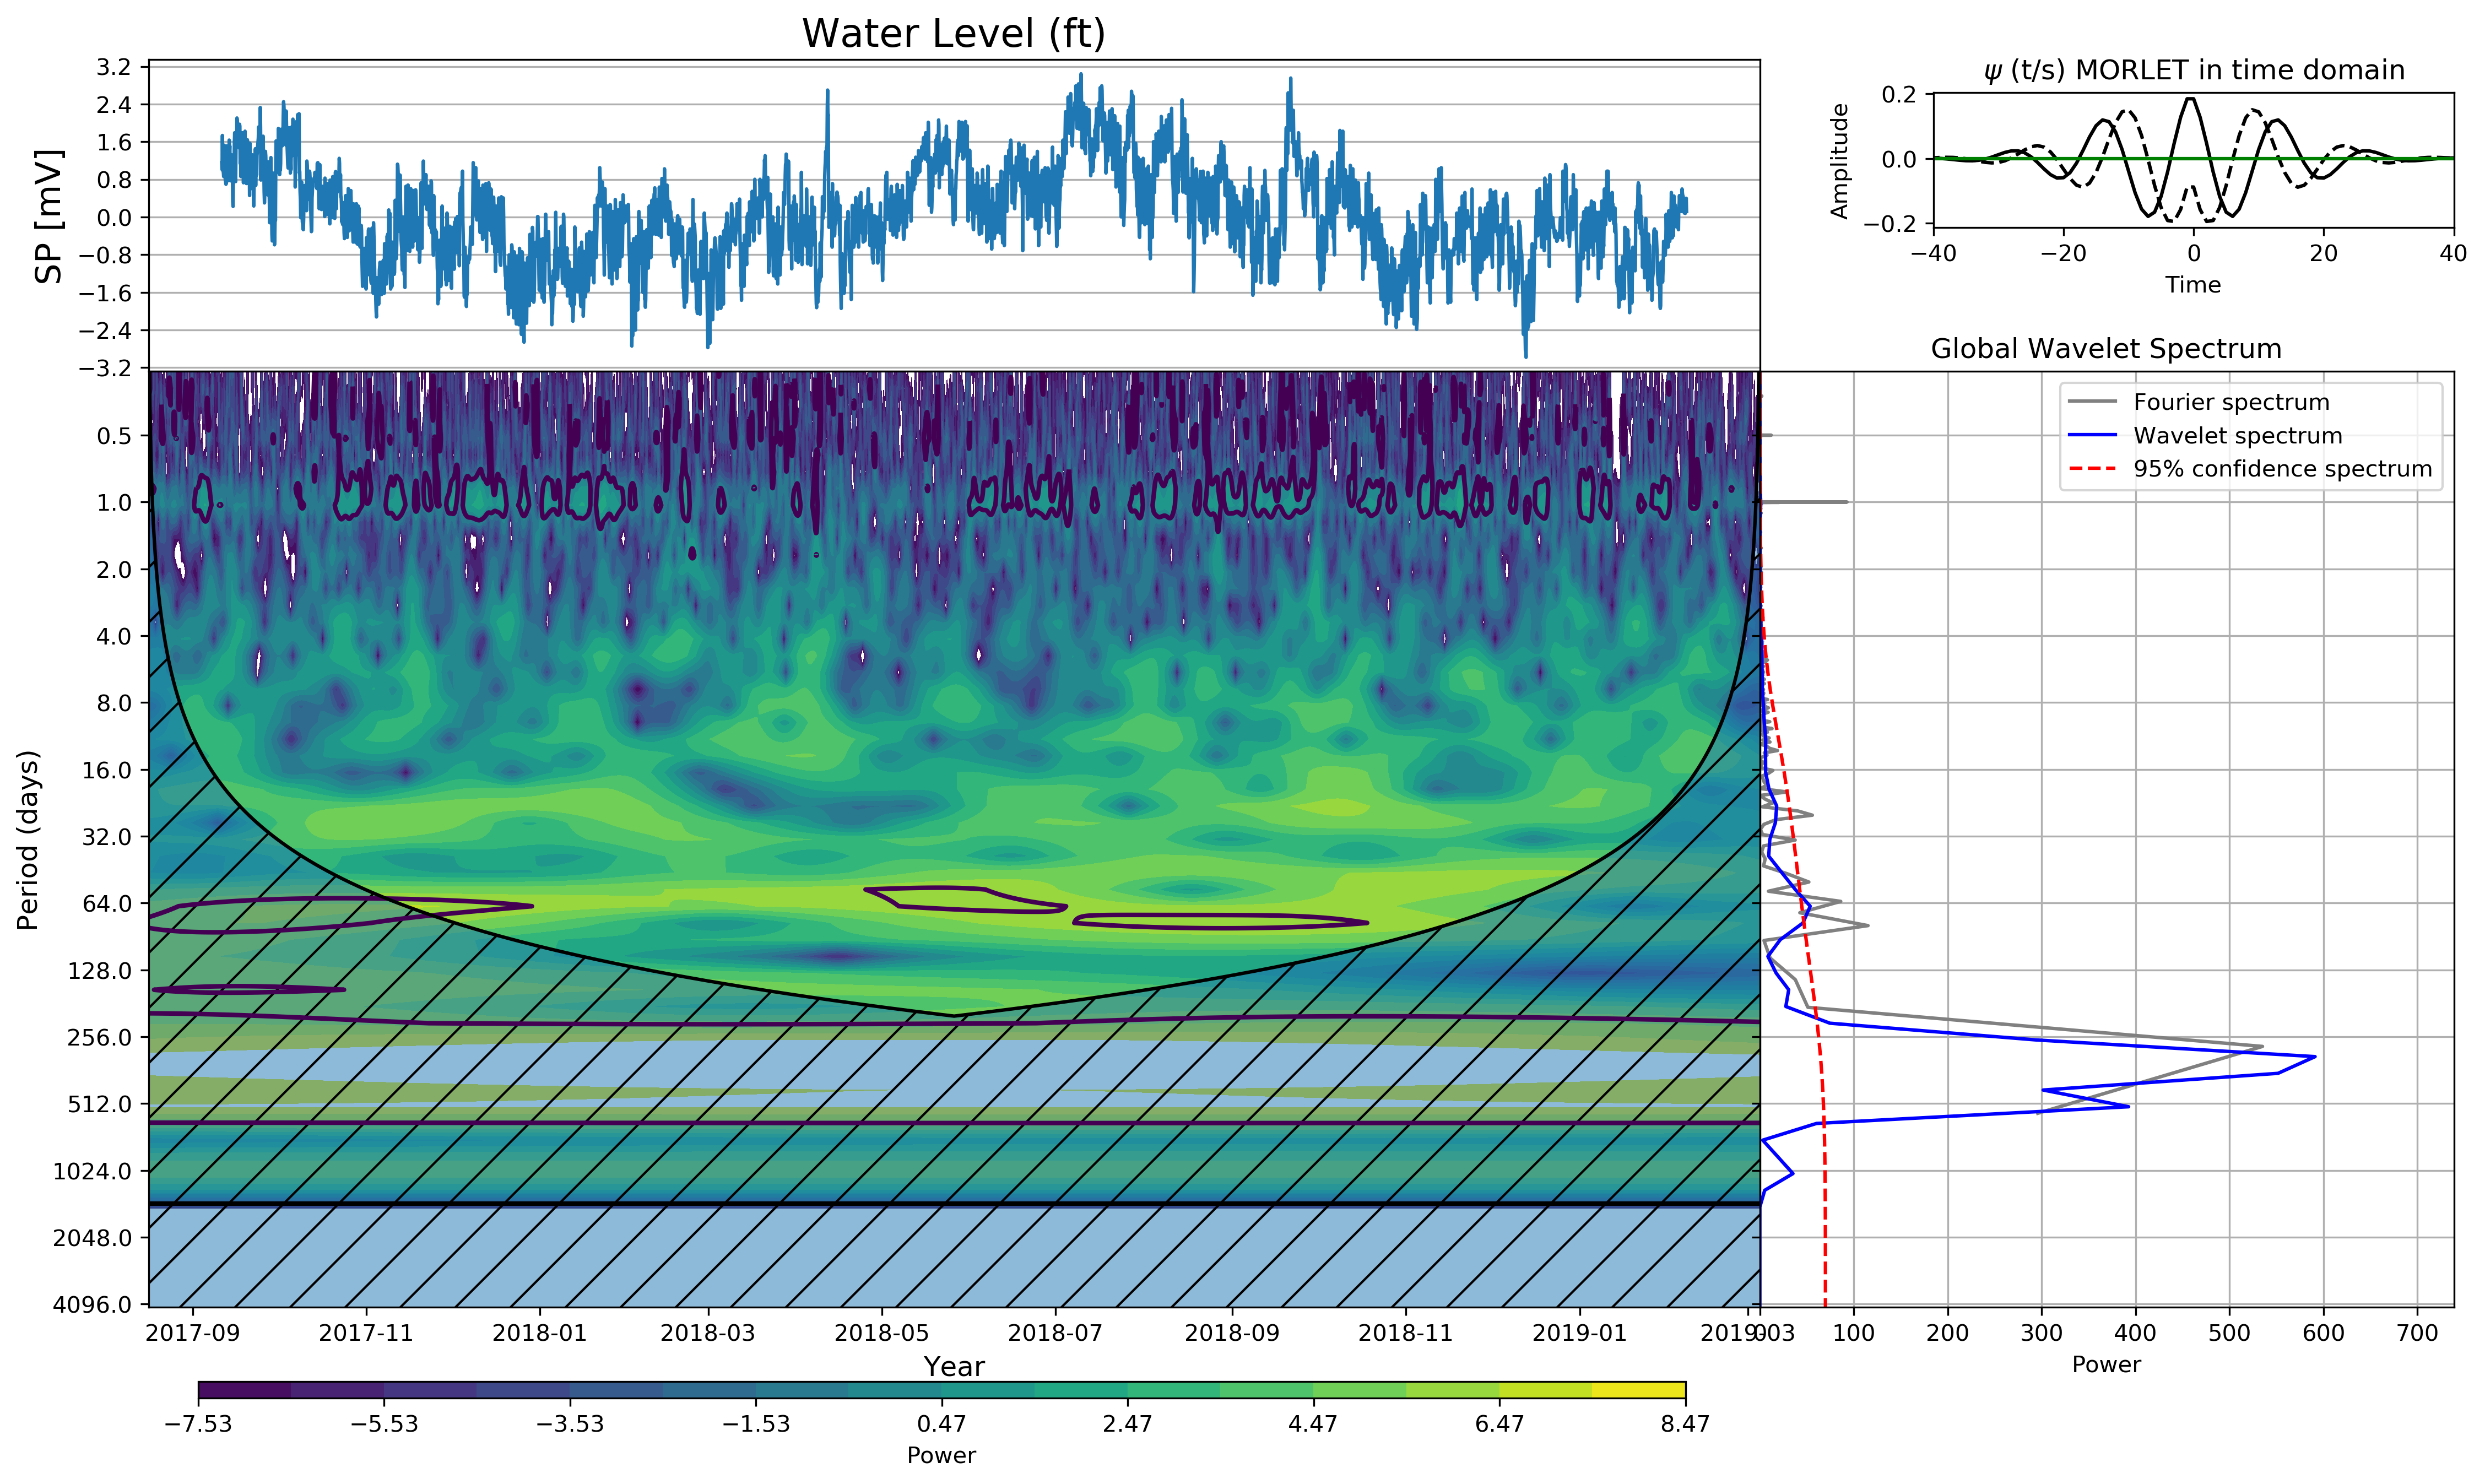

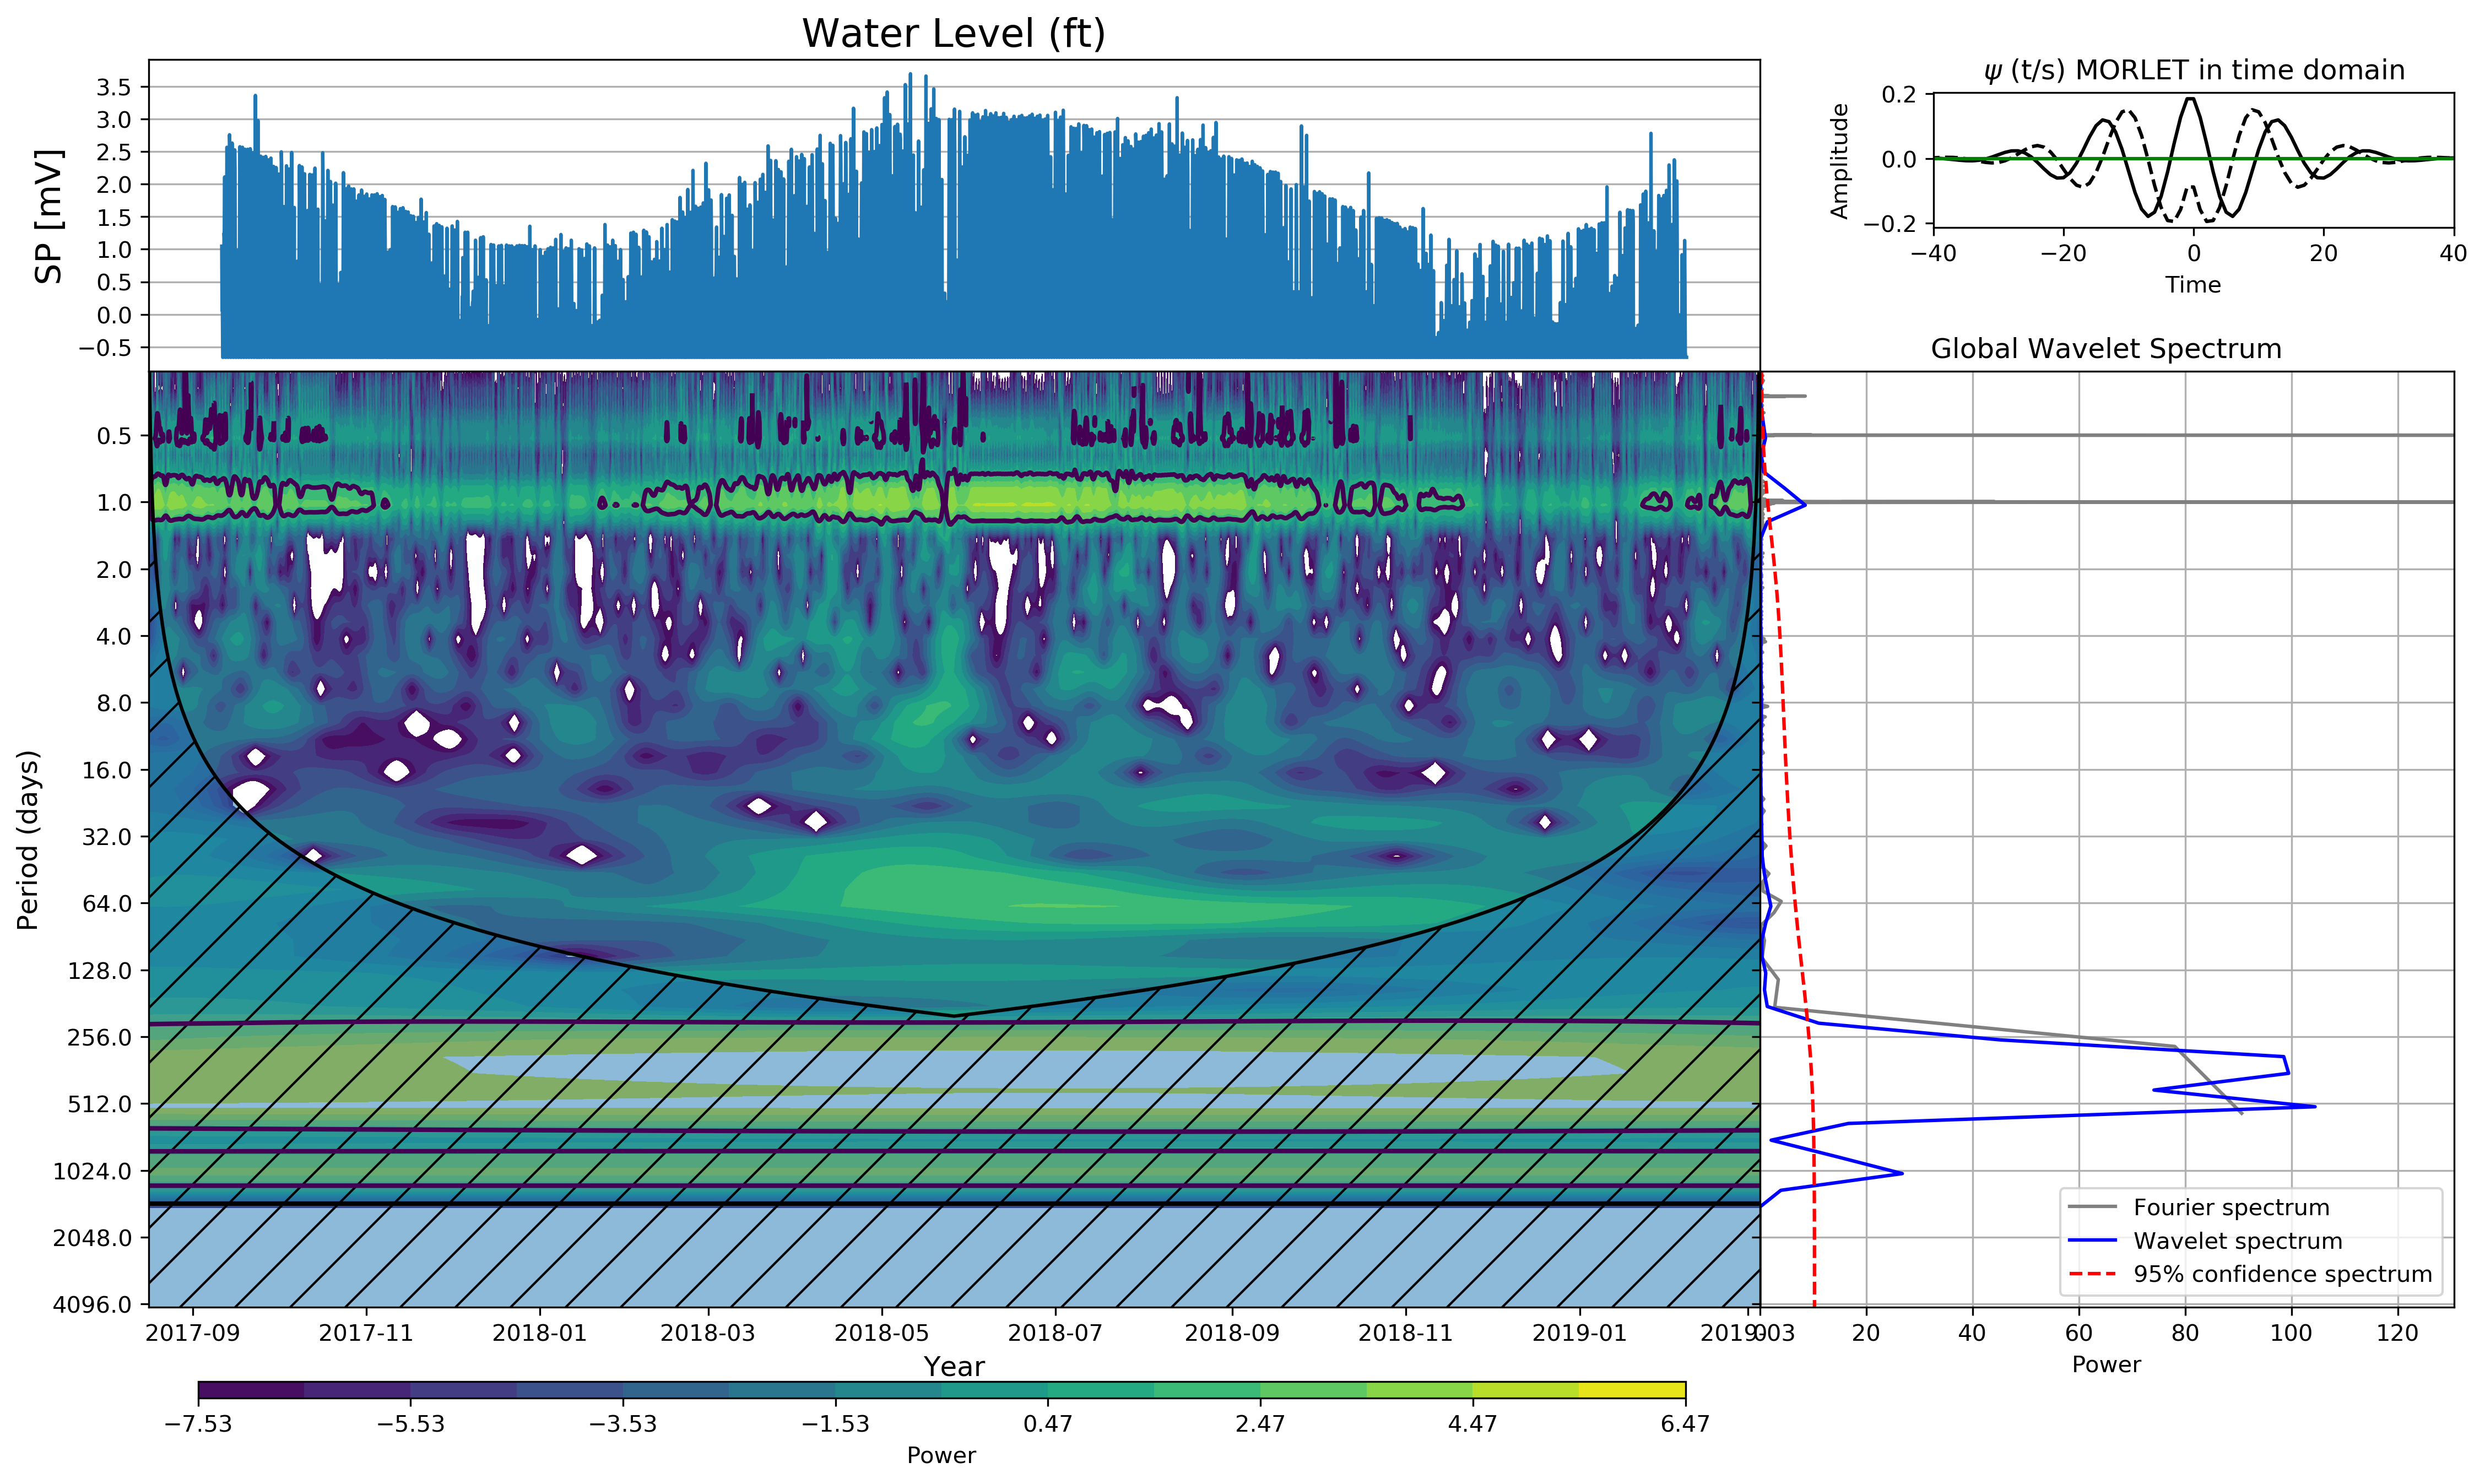

In [155]:
fig, ax, result, data =make_waves(ugs_clim_raw, varib='DewPt')

mindt = data.first_valid_index()
maxdt = data.last_valid_index()

fig1, ax1, result1, data1 =make_waves(ugs_clim_raw, mindt=mindt, maxdt=maxdt,
                                      varib='SolarRadiation1')

In [156]:
cross_power, coherence, phase_angle = waipy.cross_wavelet(result['wave'], 
                                                          result1['wave'])


C:\Users\paulinkenbrandt\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone1\lib\site-packages\numpy\ma\core.py:2788: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


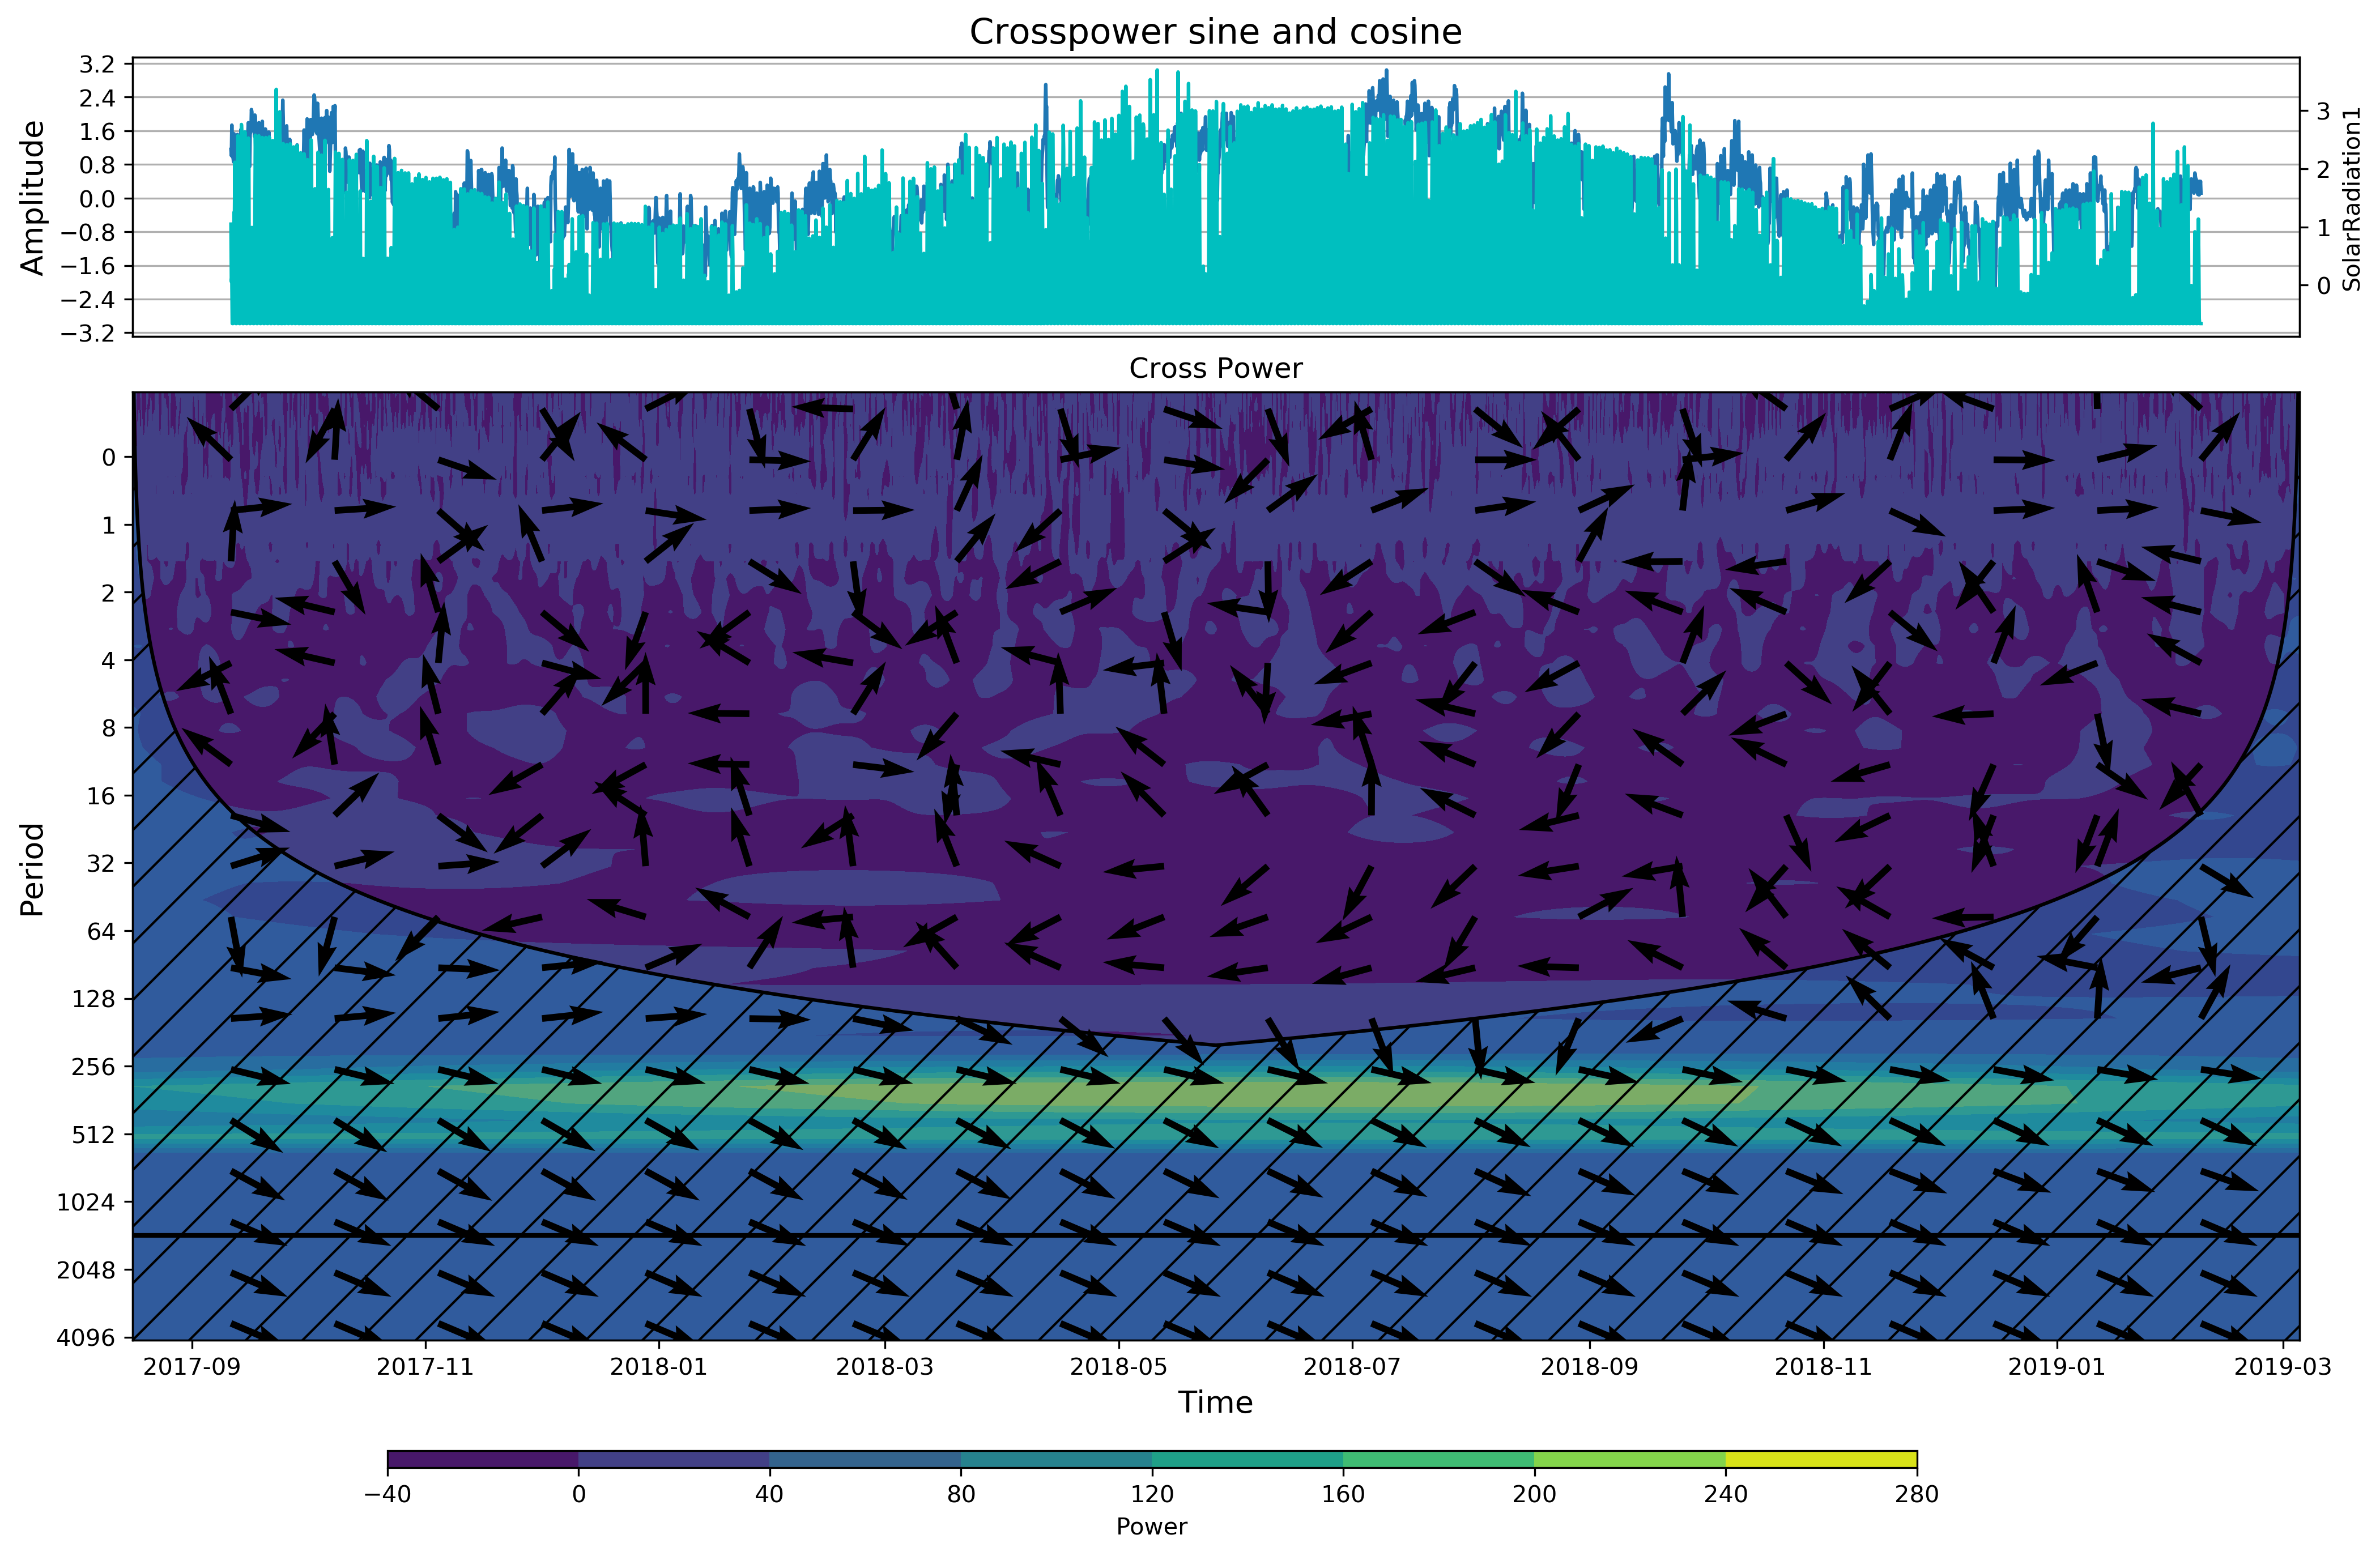

In [157]:
figname='example1.png'
waipy.plot_cross('Crosspower sine and cosine', cross_power, phase_angle, 
                 data.index, result, result1, figname)

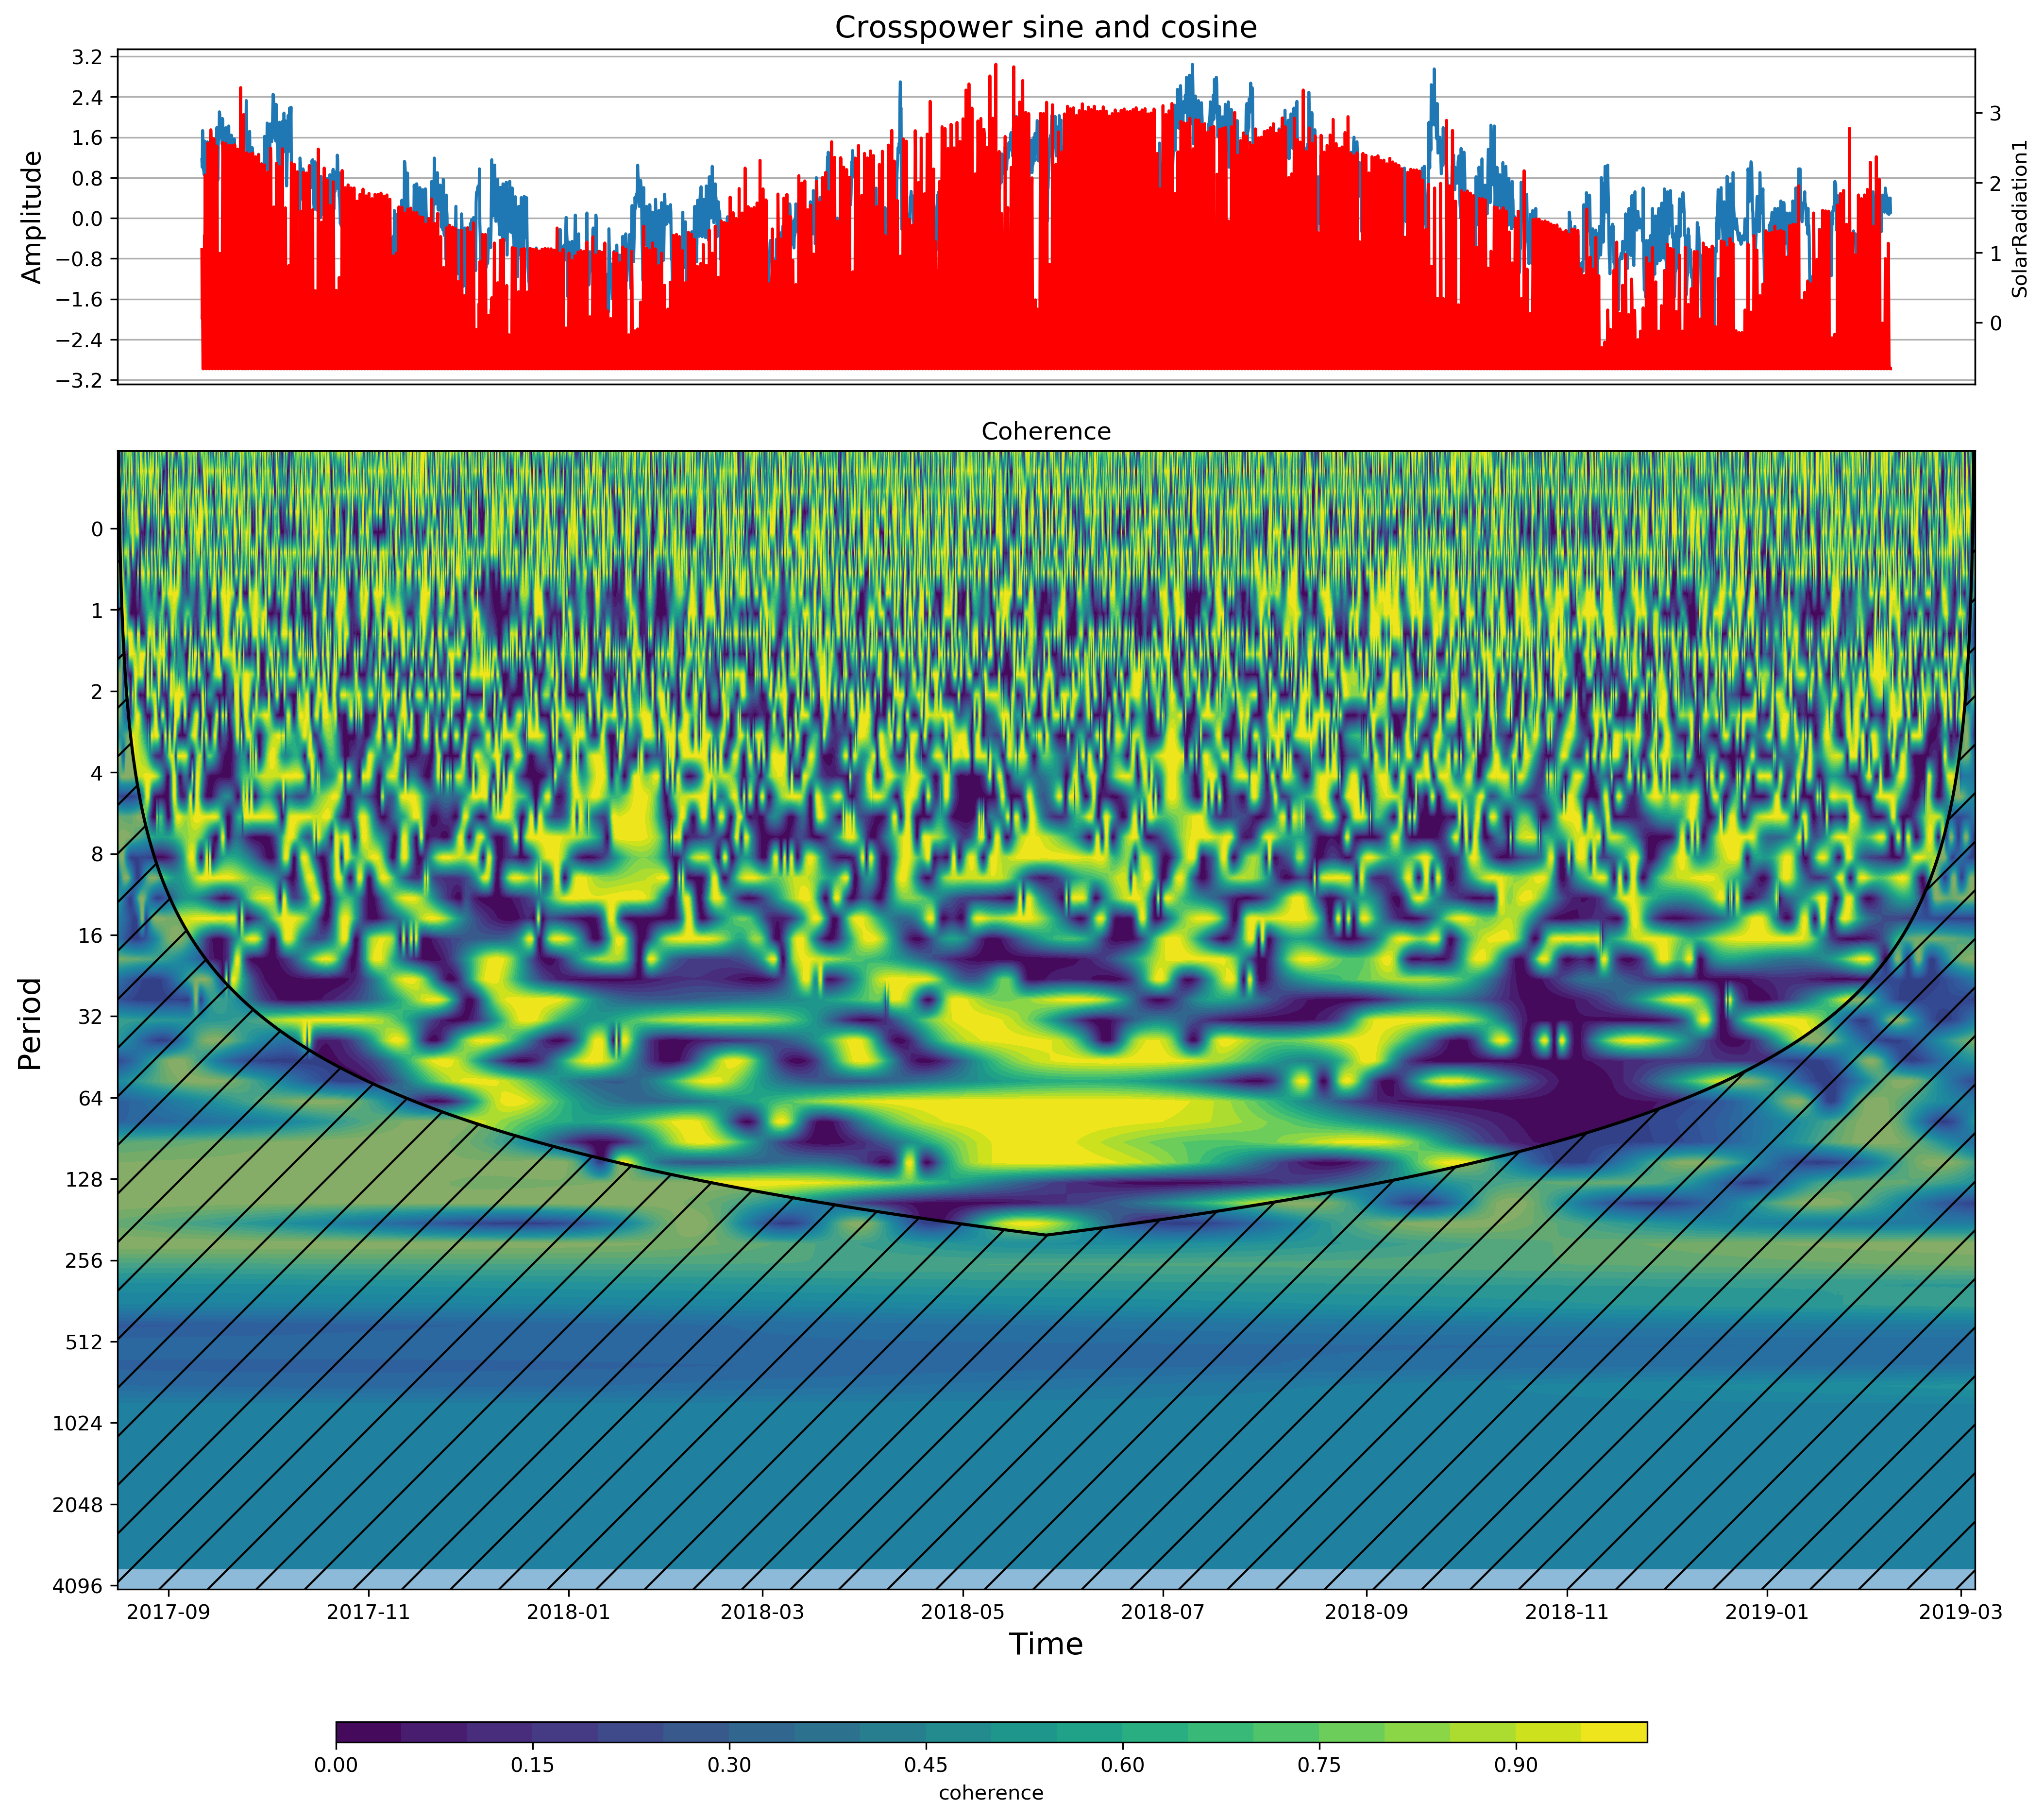

In [160]:
waipy.plot_cohere('Crosspower sine and cosine', coherence, data.index, result, result1, figname)

# Other Wavelet Methods

In [ ]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,data*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('NINO3 SST (degC)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contour(time,np.log2(period),np.log2(power),np.log2(levels))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels), extend='both', cmap=plt.get_cmap('rainbow'))
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_ws,np.log2(period),"r-")
cx.plot(global_signif,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_ws)])

#########################################
#   d) Scale average Spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avg,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signif,scaleavg_signif],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')
plt.savefig("nino3_TorrenceCompo.png")

In [ ]:
########################
#  Spectrum
########################
powers=np.zeros_like(power)
for k in range(len(scale)):
    powers[k,:] = power[k,:]/scale[k]
#significance: sig95 is already normalized = 1

########################
#  Spectrum
########################
global_wss = global_ws/scale   
global_signifs=global_signif/scale

########################
#  Scale-average between El Nino periods of 2--8 years
########################
# No need to change 
# because in Eqn(24) of Torrence and Compo [1998], division by scale has been done.
scale_avgs=scale_avg
scaleavg_signifs=scaleavg_signif

In [ ]:
#figure size
fig=plt.figure(figsize=(10,10))

# subplot positions
width= 0.65
hight = 0.28;
pos1a = [0.1, 0.75, width, 0.2]
pos1b = [0.1, 0.37, width, hight]
pos1c = [0.79, 0.37, 0.18, hight]
pos1d = [0.1,  0.07, width, 0.2]

#########################################
#---- a) Original signal
#########################################
ax=fig.add_axes(pos1a)
#original
ax.plot(time,data*np.sqrt(variance)+mean,"r-")
#reconstruction
ax.plot(time,iwave*np.sqrt(variance)+mean,"k--")

ax.set_ylabel('NINO3 SST (degC)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

#########################################
#   b) Wavelet spectrum
#########################################

#--- Contour plot wavelet power spectrum
bx=fig.add_axes(pos1b,sharex=ax)
levels = [0.0625,0.125,0.25,0.5,1,2,4,8,16] 
Yticks = 2**(np.arange(np.int(np.log2(np.min(period))),np.int(np.log2(np.max(period)))+1))
bx.contour(time,np.log2(period),np.log2(powers),np.log2(levels))
bx.contourf(time,np.log2(period),np.log2(powers),np.log2(levels), extend='both', cmap=plt.get_cmap('rainbow'))
bx.set_xlabel('Time (year)')
bx.set_ylabel('Period (years)')
import matplotlib.ticker as ticker
ymajorLocator=ticker.FixedLocator(np.log2(Yticks))
bx.yaxis.set_major_locator( ymajorLocator )
ticks=bx.yaxis.set_ticklabels(Yticks)
plt.title('b) Wavelet Power Spectrum')

# 95% significance contour, levels at -99 (fake) and 1 (95% signif)
cs = bx.contour(time,np.log2(period),sig95,[1],color='k',linewidth=1)

# cone-of-influence, anything "below" is dubious
ts = time;
coi_area = np.concatenate([[np.max(scale)], coi, [np.max(scale)],[np.max(scale)]])
ts_area = np.concatenate([[ts[0]], ts, [ts[-1]] ,[ts[0]]]);
L = bx.plot(ts_area,np.log2(coi_area),'k',linewidth=3)
F=bx.fill(ts_area,np.log2(coi_area),'k',alpha=0.3,hatch="x")

#########################################
#   c) Global Wavelet spectrum
#########################################

#--- Plot global wavelet spectrum
cx=fig.add_axes(pos1c,sharey=bx)
cx.plot(global_wss,np.log2(period),"r-")
cx.plot(global_signifs,np.log2(period),'k--')
ylim=cx.set_ylim(np.log2([period.min(),period.max()]))
cx.invert_yaxis()
plt.title('c) Global Wavelet Spectrum')
xrangec=cx.set_xlim([0,1.25*np.max(global_wss)])

#########################################
#   d) Global Wavelet spectrum
#########################################
#--- Plot Scale-averaged spectrum -----------------
dx=fig.add_axes(pos1d,sharex=bx)
dx.plot(time,scale_avgs,"r-")
dx.plot([time[0],time[-1]],[scaleavg_signifs,scaleavg_signifs],"k--")
xrange=dx.set_xlim(xlim)
dx.set_ylabel('Avg variance (degC$^2$)')
title=plt.title('d) Scale-average Time Series')

## Using Scaleogram

In [ ]:
import scaleogram as scg
df = ugs_clim_raw_dly.loc['USW00053138','Max Temperature'].resample('1D').interpolate(method='time').dropna()
df_normed = df - df.mean()
datetime_lim = [df.index.min(), df.index.max()] 
years_lim = [df.index.min().year, df.index.max().year]

def set_x_yearly(ax, days, start_year=1969):
    xlim  = (np.round([0, days]) / 365.25).astype(np.int32)
    ticks = np.arange(xlim[0], xlim[1])
    ax.set_xticks(ticks*365)
    ax.set_xticklabels(start_year + ticks)

fig = plt.figure(figsize=(12,2))
lines = plt.plot(df.index, df.values/1000, '-')
plt.xlim(datetime_lim)

plt.ylabel("Nb of birthes [k]"); plt.title("Max Temp per Day");
xlim = plt.xlim()
scales = scg.periods2scales(np.arange(100, 365.25*1.5, 1))
ax = scg.cws(df_normed, scales = scales, figsize=(13.2, 4), xlabel="Year", 
             ylabel="Nb of Day")
set_x_yearly(ax, len(df),start_year=df.index.min().year)

In [ ]:
from scipy import signal
freqs, psd = signal.welch(df_normed, scaling='spectrum', nperseg=1024)

plt.figure(figsize=(10, 6))
plt.plot(1/freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.tight_layout()
plt.grid()